# Introduction

The aim of this notebook is to introduce the calculation of a Bayesian network score, generate a sequence of networks and compare their scores, and finally determine the conditional probabilities inherent in a network. We will also compare the conditional probability approach via Bayesian networks and naive Bayesian classification.

# Handling Bayesian networks

We use the two files `titanic.gph` & `wine.gph` to generate Bayesian networks in graph form. We'll use `networkx` to perform this modeling, in the form of a directed graph.

In [34]:
import networkx as nx

def graph_from_gph(path:str)->nx.DiGraph:
    edges = [tuple(l.strip('\n').split(', ')) for l in open(path).readlines()]
    graph = nx.DiGraph()
    graph.add_edges_from(edges)
    return graph

titanic_graph:nx.DiGraph = graph_from_gph('../titanic.gph')
wine_graph:nx.DiGraph = graph_from_gph('../wine.gph')

For our two datasets:

In [35]:
import pandas as pd

titanic_df:pd.DataFrame = pd.read_csv('datasets/small.csv')
wine_df:pd.DataFrame = pd.read_csv('datasets/medium.csv')

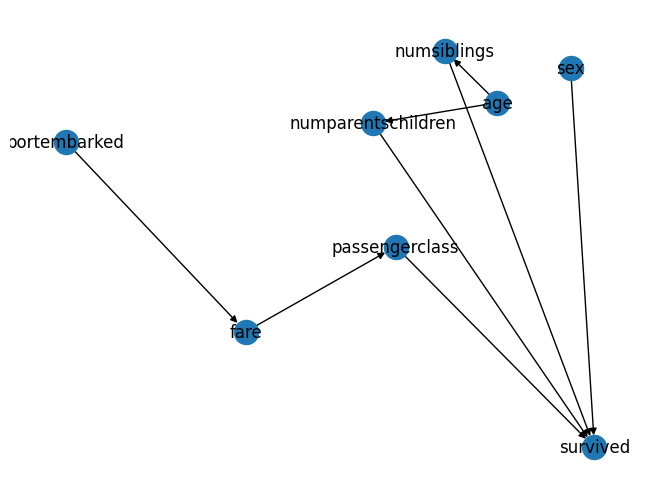

In [36]:
# Titanic graph

from matplotlib import pyplot as plt
nx.draw(titanic_graph, with_labels=True)
plt.show()

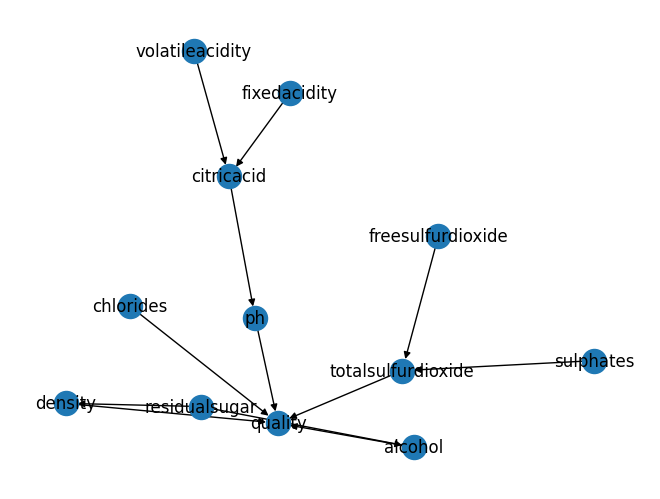

In [37]:
# Wine graph

from matplotlib import pyplot as plt
nx.draw(wine_graph, with_labels=True)
plt.show()

# Estimating the number of DAGs possible for each dataset

We've coded a function to estimate the number of DAGs (Directed Acyclic Graph) for a given order n. This gives the number of possibilities for our two datasets. This gives the number of possibilities for our two datasets.

In [38]:
from math import comb

def maxDAG(n:int)->int:
    if n == 0 :
        return 1
    else :
        res = 0
        for i in range(1, n + 1):
            res+=((-1)**(i-1))*comb(n, i)*(2**(i*(n-i)))*maxDAG(n-i)
        return res

For our two datasets, we obtain :

In [39]:
{
    "titanic": maxDAG(titanic_df.columns.__len__()),
    "wine": maxDAG(wine_df.columns.__len__())
}

{'titanic': 783702329343, 'wine': 521939651343829405020504063}

# Calculating the score of a network

As inspiration, we'll use the mathematical function score(G|D) to write a method for calculating the score of a Bayesian network as a function of the dataset associated with it.

To do this, we'll write a class presenting methods for calculating the following elements:

- $r_{i}$ : The number of values the variable $x_i$ can take.
  - To do this, we return the length of a set in column $x_i$.
- $q_i$: The product of the number of possible instantiations that each direct parent of $x_i$ can take.
  - To do this, we multiply the $r_i$ values of each parent
- $pi_{ij}$ : The $j$th instantiation of $x_i$'s parents, represented as a tuple
  - To do this, we generate the set of possible simultaneous instantiations as a list of tuples and, if $j$ is specified, return the tuple with index $j$.
- $m_{ijk}$ : The number of times in the dataset that $X_i$ is equal to $k$ and its parents correspond to the instantiation $\pi_{ij}$.
  - To do this, we iterate through a list of parents of $x_i$ and the list of instantiations given by $\pi_{ij}$, and increment a variable each time the condition is verified
- $score(G|D)$ : The score function needed to evaluate a graph
  - This function results from the direct implementation of the function in the statement.

In [40]:
import itertools as itrt
from mpmath import log, factorial

class Scoring:

    def __init__(self, G:nx.DiGraph, D:pd.DataFrame):
        self.G = G
        self.D = D
    

    def r(self, x_i:str)->int:
        return len(set(self.D[x_i]))


    def get_parents(self, node:str)->list:
        return list(self.G.predecessors(node))
    

    def q(self, x_i:str)->int:
        result = 1

        for i in self.get_parents(x_i):
            result *= self.r(i)
        
        return result


    def get_possible_instances(self, x_i:str)->tuple:
        return tuple(set(self.D[x_i]))


    def pi(self, x_i:str, j:int=None)->list|tuple:

        parents_instances = [self.get_possible_instances(parent) for parent in self.get_parents(x_i)]

        pairs = list(itrt.product(*parents_instances))

        if j:
            assert j < len(pairs)
        
        return pairs[j] if j else pairs


    def m(self, x_i:str, j:int, k: int)->int:

        result = 0
        parents = self.get_parents(x_i)

        if k == 0:

            for new_k in range(self.r(x_i)):
                result += self.m(x_i, j, new_k+1)
            
            return result
                
        if len(parents) != 0:
            
            instances = self.pi(x_i)
        
            for i, value in enumerate(self.D[x_i]):
        
                count = 0

                for l, value in enumerate(instances[j-1]):
                    
                    if self.D[x_i][i] == k and self.D[parents[l]][i] == instances[j-1][l]:
                        count+=1
                        
                    
                if(count==len(instances[j-1])):
                    result+=1

            return result
        
        else:

            for i, value in enumerate(self.D[x_i]):
                if self.D[x_i][i] == k:
                    result+=1
                
            return result    


    def score(self)->float:
        result = 0

        for i in self.D.columns:
            temp_sum = 0

            for j in range(1,self.q(i)+1):

                temp_sum += (
                    log(factorial(self.r(i)-1)) 
                    - log(
                        factorial(self.r(i) + self.m(i,j,0) - 1)
                    ) 
                    + sum([
                        log(
                           factorial((1+self.m(i,j,z))-1)
                        ) for z in range(1,self.r(i)+1)
                    ])
                )

            result += temp_sum
            
        return float(result)

We can now calculate the score of our two graphs:

In [41]:
# Calculating the Wine dataset score takes a very long time (from several tens of minutes to over an hour). If you wish to run the calculation, change the variable below to True. Otherwise, the value displayed will be the one previously calculated.
calculate_wine_score:bool = False

scoring_titanic = Scoring(titanic_graph, titanic_df)
scoring_wine = Scoring(wine_graph, wine_df)

{
    "titanic": scoring_titanic.score(),
    "wine": scoring_wine.score() if calculate_wine_score else -43344.921630608056
}

{'titanic': -3952.558735240772, 'wine': -43344.921630608056}

# Generate a sequence of networks

Here, the aim is to generate random graphs in order to maximize the score, and thus obtain the best possible Bayesian network for the dataset provided. To do this, we write a function generating $n$ random graphs, and select the best one according to its score.

In [42]:
# The code below is our exclusive work, with the sole exception of the optimization via ThreadPoolExecutor, provided by ChatGPT.

import random as rd
from typing import List
import concurrent.futures

def create_random_graph(data:pd.DataFrame, n:int)->List[nx.DiGraph]:
    listGraphes = []

    for i in range(n):
        graph = nx.DiGraph()
        for at in data.columns:
            graph.add_node(at)
        while nx.is_directed_acyclic_graph(graph):
            randomEdge = (rd.choice(data.columns.to_list()), rd.choice(data.columns.to_list()))
            # print(randomEdge)
            if randomEdge[0] != randomEdge[1]:
                graph.add_edge(randomEdge[0], randomEdge[1])
        listGraphes.append(graph)
    return listGraphes

def best_graph(data: pd.DataFrame, n: int) -> list:
    res = []
    graphes = create_random_graph(data, n)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []

        for g in graphes:
            future = executor.submit(scoring_worker, g, data)
            futures.append(future)

        for future in concurrent.futures.as_completed(futures):
            res.append(future.result())

    return sorted(res, key=lambda x: x['score'], reverse=True)


def scoring_worker(graph, data):
    scoring = Scoring(graph, data)
    g_res = {}
    g_res["score"] = scoring.score()
    g_res["graph"] = list(graph.edges())
    return g_res

Here's an example of three graphs generated by `best_graph` for the Titanic dataset, with their scores sorted in descending order.

In [43]:
best_graph(titanic_df, 3)

[{'score': -4116.071134914941,
  'graph': [('age', 'survived'),
   ('portembarked', 'fare'),
   ('fare', 'passengerclass'),
   ('numparentschildren', 'numsiblings'),
   ('passengerclass', 'numparentschildren'),
   ('numsiblings', 'passengerclass')]},
 {'score': -4121.846975485811,
  'graph': [('age', 'passengerclass'),
   ('fare', 'portembarked'),
   ('fare', 'sex'),
   ('fare', 'numparentschildren'),
   ('fare', 'age'),
   ('passengerclass', 'fare'),
   ('survived', 'portembarked')]},
 {'score': -4184.112867025709,
  'graph': [('portembarked', 'numsiblings'),
   ('numparentschildren', 'survived'),
   ('survived', 'numsiblings'),
   ('survived', 'numparentschildren')]}]

And an example of three graphs for the Wine dataset. Note that, like the `score()` method demonstration, generating the graphs for the Wine dataset takes a considerable amount of time (several minutes).

In [44]:
# The variable below is set to False by default. In this case, the graphs displayed come from a previous run and are stored in a variable. To start generation (which may take several minutes), you can change the value of this variable to True.
generate_wine_graphs:bool = False

best_graph(wine_df, 3) if generate_wine_graphs else [
    {
        'score': -44208.999426677736,
        'graph': [('volatileacidity', 'quality'),
        ('volatileacidity', 'totalsulfurdioxide'),
        ('citricacid', 'quality'),
        ('residualsugar', 'volatileacidity'),
        ('residualsugar', 'density'),
        ('freesulfurdioxide', 'totalsulfurdioxide'),
        ('totalsulfurdioxide', 'freesulfurdioxide'),
        ('ph', 'residualsugar'),
        ('ph', 'freesulfurdioxide'),
        ('ph', 'citricacid')]
    },
    {
        'score': -45512.75124596456,
        'graph': [('fixedacidity', 'volatileacidity'),
        ('residualsugar', 'quality'),
        ('residualsugar', 'freesulfurdioxide'),
        ('chlorides', 'sulphates'),
        ('chlorides', 'quality'),
        ('density', 'fixedacidity'),
        ('density', 'citricacid'),
        ('ph', 'freesulfurdioxide'),
        ('ph', 'quality'),
        ('sulphates', 'freesulfurdioxide'),
        ('alcohol', 'chlorides'),
        ('alcohol', 'ph'),
        ('quality', 'ph')]
   },
   {
        'score': -45838.35246489307,
        'graph': [('volatileacidity', 'chlorides'),
        ('chlorides', 'alcohol'),
        ('ph', 'volatileacidity'),
        ('ph', 'citricacid'),
        ('sulphates', 'volatileacidity'),
        ('sulphates', 'chlorides'),
        ('alcohol', 'freesulfurdioxide'),
        ('alcohol', 'chlorides')]
   }
]

[{'score': -44208.999426677736,
  'graph': [('volatileacidity', 'quality'),
   ('volatileacidity', 'totalsulfurdioxide'),
   ('citricacid', 'quality'),
   ('residualsugar', 'volatileacidity'),
   ('residualsugar', 'density'),
   ('freesulfurdioxide', 'totalsulfurdioxide'),
   ('totalsulfurdioxide', 'freesulfurdioxide'),
   ('ph', 'residualsugar'),
   ('ph', 'freesulfurdioxide'),
   ('ph', 'citricacid')]},
 {'score': -45512.75124596456,
  'graph': [('fixedacidity', 'volatileacidity'),
   ('residualsugar', 'quality'),
   ('residualsugar', 'freesulfurdioxide'),
   ('chlorides', 'sulphates'),
   ('chlorides', 'quality'),
   ('density', 'fixedacidity'),
   ('density', 'citricacid'),
   ('ph', 'freesulfurdioxide'),
   ('ph', 'quality'),
   ('sulphates', 'freesulfurdioxide'),
   ('alcohol', 'chlorides'),
   ('alcohol', 'ph'),
   ('quality', 'ph')]},
 {'score': -45838.35246489307,
  'graph': [('volatileacidity', 'chlorides'),
   ('chlorides', 'alcohol'),
   ('ph', 'volatileacidity'),
   ('ph',

## Limitations

We have observed a number of limitations to the generation of random graphs with associated scores. The main limitation is that the generated graph respects neither the logical conditions relating to the nodes (we can obtain graphs with nonsensical connections), nor the distribution of values in the dataset that can justify the connections generated.

The aim is to filter out the most coherent graphs through human analysis, before filtering them by their score.

# Determining conditional probabilities

Our aim here is to write the probability tables for our Bayesian networks, using a function $P(data|conditions)$.

In short, to obtain a conditional probability from a query of type $P(data=4 | data_a=1, data_b=2, data_c=3, ...)$.

To do this, we code the `p` function. This function will, for each condition, restrict the dataset, then finally return the proportion where the data is equal to the indicated value, in this reduced dataset.

In [45]:
from typing import Dict

def p(dataframe:pd.DataFrame, x:str, valeurX:int, **conditions:Dict[str, int])->float:
    df_copy:pd.DataFrame = dataframe

    for key, value in conditions.items():
        df_copy = df_copy.loc[df_copy[key] == value]

    result = len([i for i in df_copy[x] if i == valeurX])/df_copy.__len__()

    return round(result, 3)

Here are a few examples:

In [46]:
# Dataset Titanic
{
    "P(survived=1 | passengerclass=1, numparentschildren=1, numsiblings=1, sex=1)": p(titanic_df, "survived", 1, passengerclass=1, numparentschildren=1, numsiblings=1, sex=1),
    "P(passengerclass=3 | fare=1)": p(titanic_df, "passengerclass", 3, fare=1),
    "P(survived=2 | numparentschildren=2, numsiblings=3)": p(titanic_df, "survived", 2, numparentschildren=2, numsiblings=1)
}

{'P(survived=1 | passengerclass=1, numparentschildren=1, numsiblings=1, sex=1)': 0.86,
 'P(passengerclass=3 | fare=1)': 0.212,
 'P(survived=2 | numparentschildren=2, numsiblings=3)': 0.667}

In [47]:
# Dataset Wine
{
    "P(quality=4 | alcohol=3, density=1, ph=2, totalsulfurdioxide=1)": p(wine_df, "quality", 4, alcohol=3, density=1, ph=2, totalsulfurdioxide=1),
    "P(totalsulfurdioxide=2 | sulphates=5, freesulfurdioxide=1)": p(wine_df, "totalsulfurdioxide", 2, sulphates=5, freesulfurdioxide=1),
    "P(quality=1 | ph=1, alcohol=2)": p(wine_df, "quality", 1, ph=1, alcohol=2)
}

{'P(quality=4 | alcohol=3, density=1, ph=2, totalsulfurdioxide=1)': 0.167,
 'P(totalsulfurdioxide=2 | sulphates=5, freesulfurdioxide=1)': 0.818,
 'P(quality=1 | ph=1, alcohol=2)': 0.135}

Thus, iterating with this function produces the set of conditional probabilities of the graphs. However, considering the size of the latter, we didn't consider it useful to model these tables by exhaustively applying this function.

# Comparison with naive Bayesian classification

To do this, we create two functions:
- The first, iterating over the rows of the dataset supplied as a parameter, counts the correct predictions using our previously coded `p` function, which takes as input the parents of the target node and the associated graph. This count is then divided by the length of the dataset.
- The second uses a naive bayes classifier from sklearn. It divides the dataset into components y (the target column) and X (all other columns). After creating a training and test X & y set, we train the classifier before displaying its score with the test data, corresponding to its accuracy.

In [48]:
def calculate_accuracy_with_bayes_network(graph:nx.DiGraph, data:pd.DataFrame, target_node:str)->float:

    rows:List[dict] = list(data.to_dict(orient='index').values())
    possible_values = set(data[target_node])

    result = 0

    for row in rows:

        kwargs = {p: row[p] for p in graph.predecessors(target_node)}

        computed_probability = {i: p(data, target_node, i, **kwargs) for i in possible_values}

        closest_to_one = max(computed_probability, key=computed_probability.get)

        if closest_to_one == row[target_node]:
            result +=1

    return result/data.__len__()

{
    "titanic": calculate_accuracy_with_bayes_network(titanic_graph, titanic_df, 'survived'),
    "wine": calculate_accuracy_with_bayes_network(wine_graph, wine_df, 'quality')
}

{'titanic': 0.8098987626546682, 'wine': 0.5089832584728461}

In [49]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

def calculate_accuracy_with_naive_bayes(data:pd.DataFrame, target_column:str)->float:

    y = data[target_column]
    X = data.drop(target_column, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=0)

    X_train = X_train.to_numpy()
    X_test = X_test.to_numpy()
    y_train = y_train.to_numpy()
    y_test = y_test.to_numpy()

    classifier = GaussianNB()
    classifier.fit(X_train, y_train)

    return classifier.score(X_test, y_test)

{
    "titanic": calculate_accuracy_with_naive_bayes(titanic_df, 'survived'),
    "wine": calculate_accuracy_with_naive_bayes(wine_df, 'quality')
}

{'titanic': 0.7191011235955056, 'wine': 0.3153061224489796}